## CIFAR10 Dataset 신경망으로 훈련

### imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### 데이터 적재

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [4]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)
print(train_images[0].shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
(32, 32, 3)


In [5]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
train_labels[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

### 데이터 시각화

In [7]:
train_labels = np.int32(train_labels.flatten())

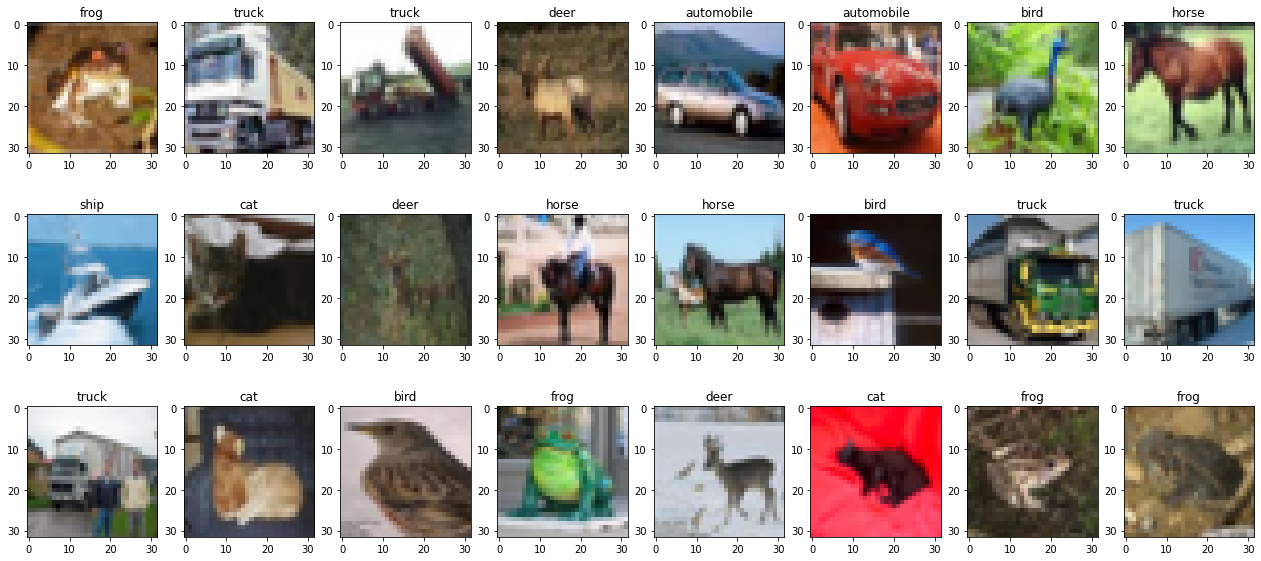

In [8]:
figure, axes = plt.subplots(figsize=(22, 10), nrows=3, ncols=8)

for i in range(3):
    for j in range(8):
        axes[i][j].imshow(train_images[(i*8)+j])
        axes[i][j].set_title(class_names[train_labels[(i*8)+j]])


### 데이터 전처리

In [9]:
train_images = np.array(train_images/255.0, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.float32)
test_images = np.array(test_images/255.0, dtype=np.float32)
test_labels = np.array(test_labels, dtype=np.float32)

train_oh_labels = to_categorical(train_labels)
test_oh_labels = to_categorical(test_labels)

train_images, valid_images, train_oh_labels, valid_oh_labels = train_test_split(train_images, train_oh_labels, test_size=0.2, random_state=42)

In [10]:
train_images.shape, valid_images.shape, train_oh_labels.shape, valid_oh_labels.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 10), (10000, 10))

### 데이터 증강(샘플 예시)

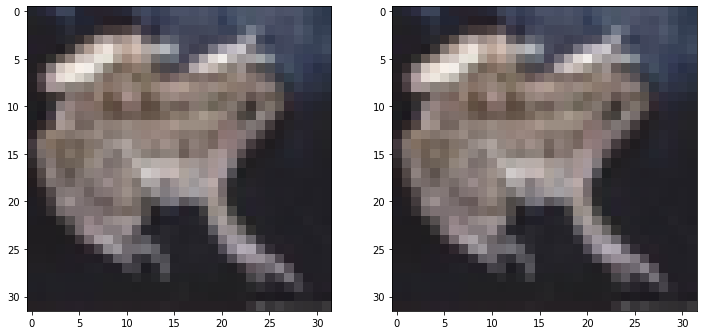

In [11]:
# data_generator = ImageDataGenerator(horizontal_flip=True) # 랜덤하게 진행하기 때문에 바뀌는 경우도 있고 아닌 경우도 있음
# data_generator = ImageDataGenerator(rotation_range=180)
data_generator = ImageDataGenerator(vertical_flip=True)

image = np.expand_dims(train_images[0], axis=0)
data_generator_iterator = data_generator.flow(image)

augmented_image = next(data_generator_iterator)

image = np.squeeze(image)
augmented_image = np.squeeze(augmented_image)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 6))
axes[0].imshow(image)
axes[1].imshow(augmented_image)

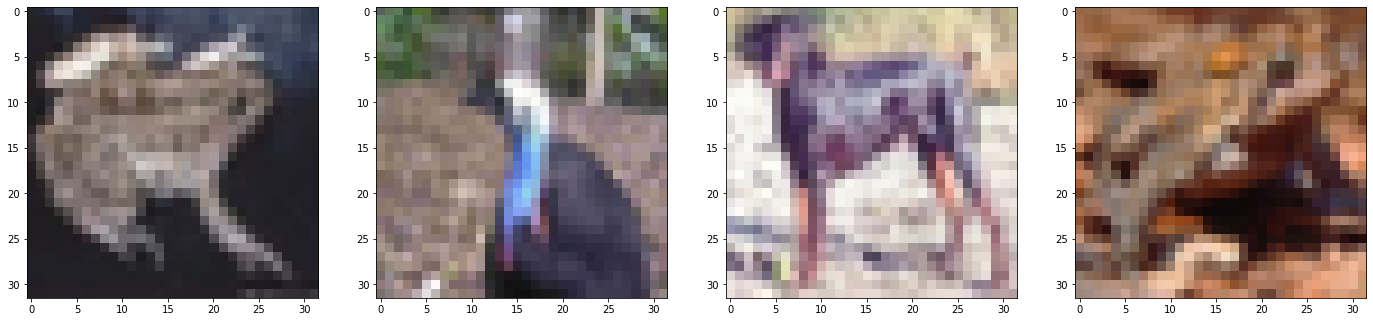

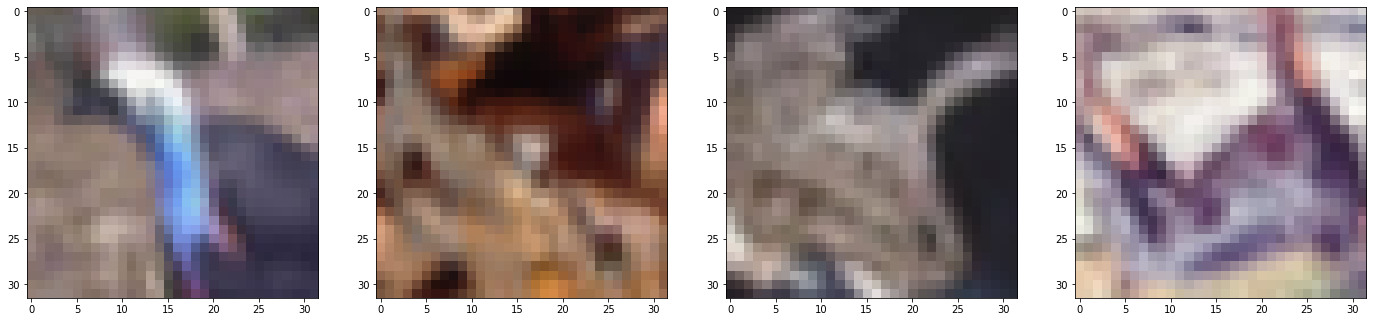

In [12]:
# data_generator = ImageDataGenerator(horizontal_flip=True) 
# data_generator = ImageDataGenerator(rotation_range=180)
# data_generator = ImageDataGenerator(vertical_flip=True)
data_generator = ImageDataGenerator(horizontal_flip=True, 
                                    rotation_range=30,
                                    vertical_flip=True, 
                                    zoom_range=(0.7, 0.9))

images = train_images[0:4]

data_generator_iterator = data_generator.flow(images)

augmented_image = next(data_generator_iterator)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6*4, 6))

for i, image in enumerate(images):
    axes[i].imshow(image)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(6*4, 6))

for i, aug_image in enumerate(augmented_image):
    axes[i].imshow(aug_image)

In [13]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(horizontal_flip=True)
train_generator_iterator = train_generator.flow(train_images, train_oh_labels, batch_size=BATCH_SIZE)

valid_generator = ImageDataGenerator(horizontal_flip=True)
valid_generator_iterator = valid_generator.flow(valid_images, valid_oh_labels, batch_size=BATCH_SIZE)

### Global Average Pooling 적용





In [14]:
def build_extended_model():
    tf.keras.backend.clear_session()

    input_tensor = Input(shape=(32, 32, 3))
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
                    
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)                 

    x = Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  

    # x = Flatten()(x)      
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)                 
    x = Dense(300, activation="relu")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(10, activation="softmax")(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

### 모델 생성 및 컴파일

In [15]:
model = build_extended_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0     

In [16]:
model.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics=["accuracy"])

### Callback 정의

In [17]:
checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True, verbose=1)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, mode="min", verbose=1)

### 모델 학습

In [19]:
history = model.fit(train_generator_iterator, epochs=40, validation_data=valid_generator_iterator, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reducelr_cb])

Epoch 1/40
1250/1250 [==============================] - 68s 32ms/step - loss: 1.6851 - accuracy: 0.3584 - val_loss: 1.6107 - val_accuracy: 0.3910

Epoch 00001: val_loss improved from inf to 1.61065, saving model to my_keras_model.h5
Epoch 2/40
1250/1250 [==============================] - 40s 32ms/step - loss: 1.2623 - accuracy: 0.5510 - val_loss: 1.3285 - val_accuracy: 0.5221

Epoch 00002: val_loss improved from 1.61065 to 1.32849, saving model to my_keras_model.h5
Epoch 3/40
1250/1250 [==============================] - 40s 32ms/step - loss: 1.0395 - accuracy: 0.6420 - val_loss: 0.9931 - val_accuracy: 0.6446

Epoch 00003: val_loss improved from 1.32849 to 0.99310, saving model to my_keras_model.h5
Epoch 4/40
1250/1250 [==============================] - 40s 32ms/step - loss: 0.8905 - accuracy: 0.6992 - val_loss: 0.9183 - val_accuracy: 0.6835

Epoch 00004: val_loss improved from 0.99310 to 0.91830, saving model to my_keras_model.h5
Epoch 5/40
1250/1250 [==============================] - 

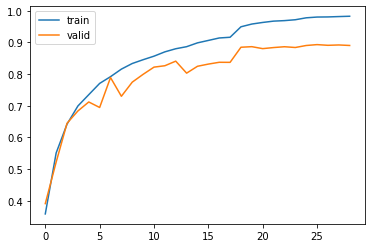

In [20]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="valid")
plt.legend()

### 테스트 데이터에 대해 평가

In [22]:
model.evaluate(test_images, test_oh_labels, batch_size=BATCH_SIZE, verbose=1)

313/313 [==============================] - 4s 12ms/step - loss: 0.4121 - accuracy: 0.8841


[0.4120880365371704, 0.8841000199317932]